In [1]:
import numpy as np
import nltk
import re
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
import time
import tensorflow as tf
import tensorflow_addons as tfa

from google.cloud import storage
from multiprocessing import Pool, Process
from optuna.integration import TFKerasPruningCallback
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import metrics
from tqdm import tqdm
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

2023-05-24 18:52:15.391466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 18:52:15.568620: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-24 18:52:15.568653: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-24 18:52:16.508183: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
bucket_name = 'fake-news-data'
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)

comments_df = pd.read_csv(f'gs://{bucket_name}/comments_sample_df.csv')
sample_df = pd.read_csv(f'gs://{bucket_name}/sample_df.csv')

In [4]:
sample_df = sample_df.sample(frac=0.1, random_state=142)

## Preprocessing sample_df to make it model ready

In [5]:
# Merge DataFrames
combined_df = pd.merge(sample_df, comments_df[['submission_id', 'body']], left_on='id', right_on='submission_id', how='left')

In [6]:
# Handle Missing Data
combined_df.fillna({'clean_title': '', 'body': '', 'average_sentiment': 0, 'upvotes_most_upvoted_comment': 0, 'upvote_ratio': 0, 'num_comments': 0}, inplace=True)

### Group the rows by id

In [7]:
# Group by the post id
grouped_df = combined_df.groupby('id').agg({
    'clean_title': 'first',   # Only takes the first instance of the clean_title
    'body': '\n'.join,  # Concatenates the comments 
    'num_comments': 'first', # Take the first instance of num_comments
    'average_sentiment': 'mean',  # Takes the mean of the sentiment scores
    'upvotes_most_upvoted_comment': 'mean',  # Takes the mean of the upvotes
    'upvote_ratio': 'first',  # Only takes the first instance of the upvote_ratio
    '6_way_label': 'first' # Only takes the first instance of the label
}).reset_index()

In [8]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Stop words removal and Stemming
    tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    
    return " ".join(tokens)

In [9]:
# Text Preprocessing
grouped_df['clean_title'] = grouped_df['clean_title'].apply(preprocess_text)
grouped_df['body'] = grouped_df['body'].apply(preprocess_text)
grouped_df['text'] = grouped_df['clean_title'] + " " + grouped_df['body']

In [10]:
# Label Encoding
# Here we consider '6_way_label' as the label.
le = LabelEncoder()
grouped_df['6_way_label_encoded'] = le.fit_transform(grouped_df['6_way_label'])

In [11]:
# Text to Sequences Conversion
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(grouped_df['text'])

In [12]:
sequences = tokenizer.texts_to_sequences(grouped_df['text'])
padded_sequences = pad_sequences(sequences, padding='post')

In [13]:
# Additional Features
additional_features = grouped_df[['upvotes_most_upvoted_comment', 'average_sentiment', 'upvote_ratio']].values

In [14]:
# Combine Text and Additional Features
#X_data = np.concatenate([padded_sequences, additional_features], axis=1)

## Load, filter and preprocess images

In [15]:
# Define parameters
BATCH_SIZE = 32
IMAGE_SIZE = [224, 224]  # Resize images to this size. Change if necessary

# GCS bucket parameters
bucket_name = 'fake-news-data'
folder_name = 'images/public_image_set'

# Image file identifiers should match those in the sample_df 'image_id' column
filepaths = [f'gs://{bucket_name}/{folder_name}/{filename}.jpg' for filename in grouped_df['id']]

In [16]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    try:
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, [192, 192])
        image /= 255.0  # normalize to [0,1] range
        return image.numpy()
    except tf.errors.InvalidArgumentError:
        return None

n_files = len(filepaths)
image_array = np.zeros((n_files, 192, 192, 3), dtype=np.float32)
valid_indices = []

# Iterate over each image file
for i, filepath in tqdm(enumerate(filepaths), total=n_files):
    image = load_and_preprocess_image(filepath)
    if image is not None:
        image_array[i] = image
        valid_indices.append(i)

  0%|          | 0/3965 [00:00<?, ?it/s]2023-05-24 18:52:19.588656: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-24 18:52:19.588701: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-24 18:52:19.588729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (python-20230512-182101): /proc/driver/nvidia/version does not exist
2023-05-24 18:52:19.589133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 3965

In [17]:
# Extract the valid indices from your data
valid_text_data = padded_sequences[valid_indices]
valid_image_data = image_array[valid_indices]
valid_additional_features = additional_features[valid_indices]
valid_labels = grouped_df.loc[valid_indices]['6_way_label_encoded']

## Train Test split

In [18]:
random_seed = 42
# Split the text data
X_train_text, X_val_text, y_train, y_val = train_test_split(
    valid_text_data, valid_labels, test_size=0.2, random_state=random_seed)

# Split the image data
X_train_images, X_val_images = train_test_split(
    valid_image_data, test_size=0.2, random_state=random_seed)

# Split the additional features
X_train_additional_features, X_val_additional_features = train_test_split(
    valid_additional_features, test_size=0.2, random_state=random_seed)

## Modelling

In [19]:
vocab_size = int(max([max(sequence) for sequence in padded_sequences]) + 1)

In [20]:
histories = []
scores = []

In [27]:
def objective(trial):
    # Define the hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dense_units = trial.suggest_categorical('dense_units', [32, 64, 128])

    # Define the text model
    text_input = Input(shape=(None,), dtype='int32', name='text')
    embedded_text = Embedding(input_dim=vocab_size, output_dim=64, input_length=200)(text_input)
    encoded_text = LSTM(lstm_units)(embedded_text)

    # Define the additional features model
    additional_features_input = Input(shape=(3,), name='additional_features')
    additional_features_output = Dense(dense_units, activation='relu')(additional_features_input)

    # Define the image model
    image_input = Input(shape=(192, 192, 3), name='image')
    mobilenet = MobileNet(include_top=False, weights='imagenet')(image_input)  # MobileNet is lighter than MobileNetV2
    encoded_image = GlobalAveragePooling2D()(mobilenet)

    # Concatenate the outputs of the three models
    concatenated = concatenate([encoded_text, encoded_image, additional_features_output])

    # Add some fully connected layers at the end
    output = Dense(dense_units, activation='relu')(concatenated)
    output = Dropout(dropout_rate)(output)
    output = Dense(dense_units, activation='relu')(output)
    output = Dropout(dropout_rate)(output)
    output = Dense(6, activation='softmax')(output)

    # Create the model
    model = Model(inputs=[text_input, image_input, additional_features_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    # Add a callback for pruning.
    callbacks = [
        TFKerasPruningCallback(trial, 'val_accuracy')
    ]

    # Fit the model
    history = model.fit([X_train_text, X_train_images, X_train_additional_features], y_train, 
                        validation_data=([X_val_text, X_val_images, X_val_additional_features], y_val), 
                        epochs=5, 
                        batch_size=32, 
                        callbacks=callbacks,
                        verbose=2)
    
    histories.append(history)
    
    # Evaluate the model
    score = model.evaluate([X_val_text, X_val_images, X_val_additional_features], y_val, verbose=0)
    
    scores.append(score[1])

    return score[1]


In [28]:
# Create a study object and optimize the objective function
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(), direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=5, n_jobs=4)

[I 2023-05-24 19:12:12,783] A new study created in memory with name: no-name-418a1b8d-530e-4346-a173-f2da6ff3fbe7


Epoch 1/5
Epoch 1/5
Epoch 1/5
Epoch 1/5
100/100 - 457s - loss: 3.8186 - sparse_categorical_accuracy: 0.2849 - val_loss: 2.8568 - val_sparse_categorical_accuracy: 0.4124 - 457s/epoch - 5s/step
Epoch 2/5
100/100 - 456s - loss: 1.8671 - sparse_categorical_accuracy: 0.3932 - val_loss: 1.3742 - val_sparse_categorical_accuracy: 0.5158 - 456s/epoch - 5s/step
Epoch 2/5
100/100 - 461s - loss: 2.9174 - sparse_categorical_accuracy: 0.2701 - val_loss: 1.6877 - val_sparse_categorical_accuracy: 0.3758 - 461s/epoch - 5s/step
Epoch 2/5
100/100 - 436s - loss: 3.5687 - sparse_categorical_accuracy: 0.3061 - val_loss: 1.4143 - val_sparse_categorical_accuracy: 0.4578 - 436s/epoch - 4s/step
Epoch 2/5
100/100 - 407s - loss: 2.4818 - sparse_categorical_accuracy: 0.4853 - val_loss: 1.7543 - val_sparse_categorical_accuracy: 0.4855 - 407s/epoch - 4s/step
Epoch 3/5
100/100 - 409s - loss: 1.3195 - sparse_categorical_accuracy: 0.5961 - val_loss: 1.0840 - val_sparse_categorical_accuracy: 0.6444 - 409s/epoch - 4s/ste

[I 2023-05-24 19:47:17,895] Trial 2 finished with value: 0.6481714844703674 and parameters: {'learning_rate': 0.00010541736374088872, 'dropout_rate': 0.2542053609122966, 'lstm_units': 128, 'dense_units': 64}. Best is trial 2 with value: 0.6481714844703674.


[I 2023-05-24 19:47:20,913] Trial 1 finished with value: 0.6229507923126221 and parameters: {'learning_rate': 1.7934090263796496e-05, 'dropout_rate': 0.12414181632023694, 'lstm_units': 32, 'dense_units': 128}. Best is trial 2 with value: 0.6481714844703674.


Epoch 1/5


[I 2023-05-24 19:47:23,961] Trial 0 finished with value: 0.6822194457054138 and parameters: {'learning_rate': 0.00017566846478121872, 'dropout_rate': 0.45252996043244065, 'lstm_units': 32, 'dense_units': 64}. Best is trial 0 with value: 0.6822194457054138.
[I 2023-05-24 19:47:47,347] Trial 3 finished with value: 0.5586380958557129 and parameters: {'learning_rate': 2.0157407751148743e-05, 'dropout_rate': 0.3288820227410168, 'lstm_units': 64, 'dense_units': 64}. Best is trial 0 with value: 0.6822194457054138.


100/100 - 139s - loss: 3.0636 - sparse_categorical_accuracy: 0.2935 - val_loss: 1.4448 - val_sparse_categorical_accuracy: 0.4552 - 139s/epoch - 1s/step
Epoch 2/5
100/100 - 121s - loss: 2.6314 - sparse_categorical_accuracy: 0.4200 - val_loss: 1.3146 - val_sparse_categorical_accuracy: 0.5536 - 121s/epoch - 1s/step
Epoch 3/5
100/100 - 121s - loss: 2.2051 - sparse_categorical_accuracy: 0.4790 - val_loss: 1.2158 - val_sparse_categorical_accuracy: 0.5839 - 121s/epoch - 1s/step
Epoch 4/5
100/100 - 121s - loss: 1.8676 - sparse_categorical_accuracy: 0.5178 - val_loss: 1.1699 - val_sparse_categorical_accuracy: 0.6040 - 121s/epoch - 1s/step
Epoch 5/5
100/100 - 122s - loss: 1.6085 - sparse_categorical_accuracy: 0.5402 - val_loss: 1.1014 - val_sparse_categorical_accuracy: 0.6356 - 122s/epoch - 1s/step


[I 2023-05-24 19:57:51,022] Trial 4 finished with value: 0.6355611681938171 and parameters: {'learning_rate': 6.644708984169755e-05, 'dropout_rate': 0.4420146409618474, 'lstm_units': 128, 'dense_units': 32}. Best is trial 0 with value: 0.6822194457054138.


In [29]:
# Print the result
best_trial = study.best_trial

print('Accuracy: {}'.format(best_trial.value))
print("Best hyperparameters: {}".format(best_trial.params))

Accuracy: 0.6822194457054138
Best hyperparameters: {'learning_rate': 0.00017566846478121872, 'dropout_rate': 0.45252996043244065, 'lstm_units': 32, 'dense_units': 64}


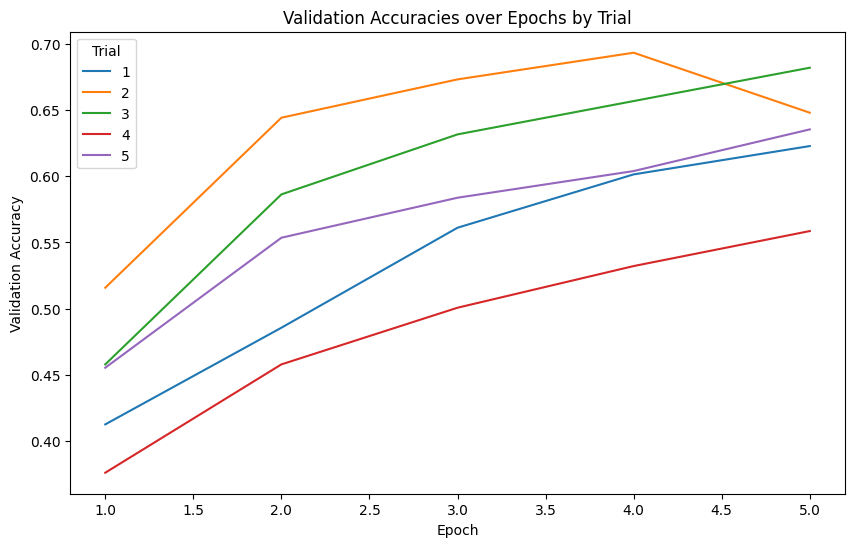

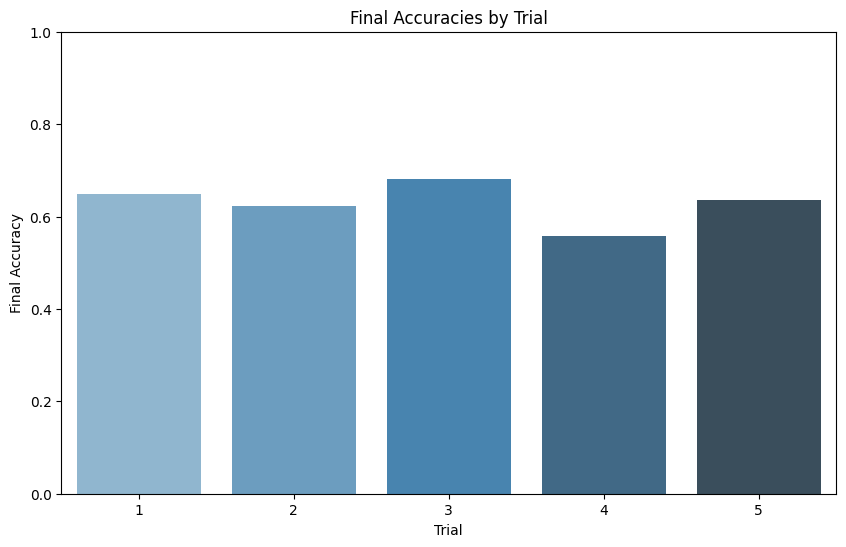

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for validation accuracies
val_acc_df = pd.DataFrame()

for i, history in enumerate(histories):
    temp_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['val_sparse_categorical_accuracy']) + 1),
        'Validation Accuracy': history.history['val_sparse_categorical_accuracy'],
        'Trial': [i + 1] * len(history.history['val_sparse_categorical_accuracy']),
    })
    val_acc_df = val_acc_df.append(temp_df, ignore_index=True)

# Line plot: Validation accuracies over epochs for each trial
plt.figure(figsize=(10, 6))
sns.lineplot(data=val_acc_df, x='Epoch', y='Validation Accuracy', hue='Trial', palette='tab10')
plt.title('Validation Accuracies over Epochs by Trial')
plt.show()

# Create a DataFrame for final accuracies
final_acc_df = pd.DataFrame({
    'Trial': range(1, len(scores) + 1),
    'Final Accuracy': scores,
})

# Bar plot: Final accuracies for each trial
plt.figure(figsize=(10, 6))
sns.barplot(data=final_acc_df, x='Trial', y='Final Accuracy', palette='Blues_d')
plt.title('Final Accuracies by Trial')
plt.ylim(0, 1)  # Set y-axis range between 0 and 1
plt.show()


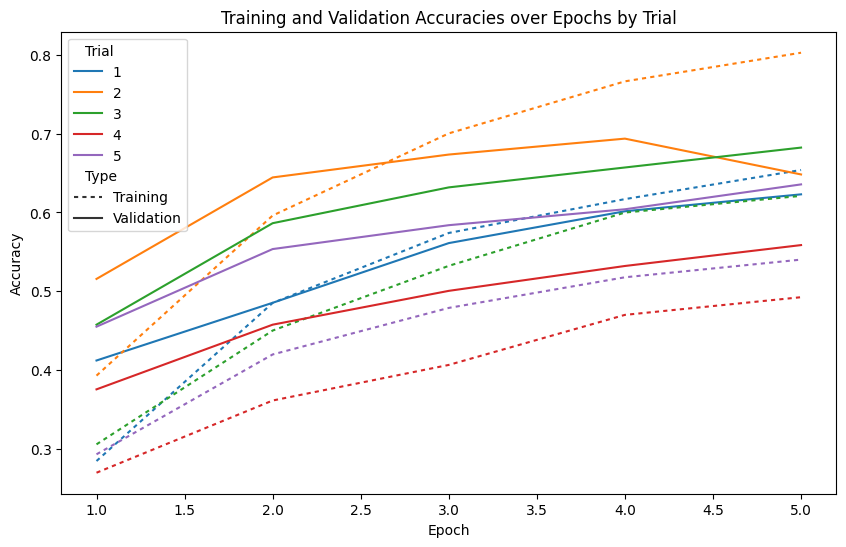

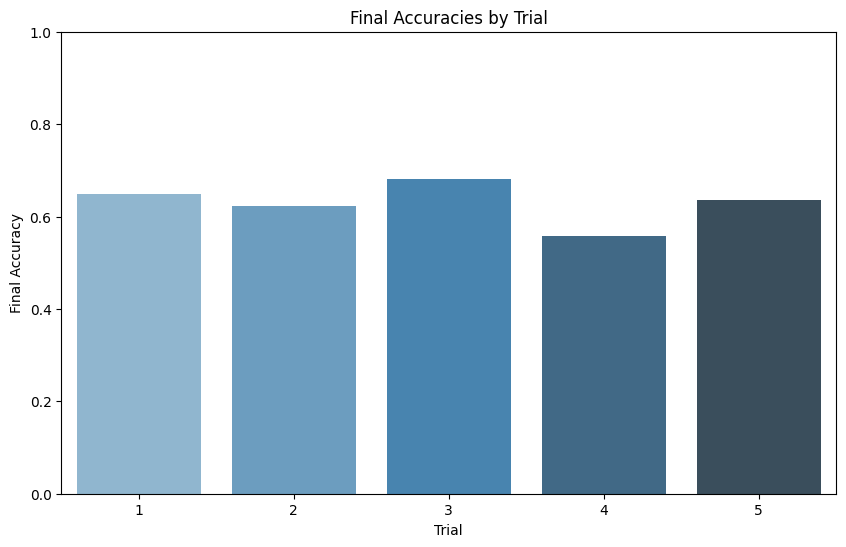

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for training and validation accuracies
acc_df = pd.DataFrame()

for i, history in enumerate(histories):
    temp_df_train = pd.DataFrame({
        'Epoch': range(1, len(history.history['sparse_categorical_accuracy']) + 1),
        'Accuracy': history.history['sparse_categorical_accuracy'],
        'Trial': [i + 1] * len(history.history['sparse_categorical_accuracy']),
        'Type': ['Training'] * len(history.history['sparse_categorical_accuracy'])
    })
    
    temp_df_val = pd.DataFrame({
        'Epoch': range(1, len(history.history['val_sparse_categorical_accuracy']) + 1),
        'Accuracy': history.history['val_sparse_categorical_accuracy'],
        'Trial': [i + 1] * len(history.history['val_sparse_categorical_accuracy']),
        'Type': ['Validation'] * len(history.history['val_sparse_categorical_accuracy'])
    })

    acc_df = acc_df.append(temp_df_train, ignore_index=True)
    acc_df = acc_df.append(temp_df_val, ignore_index=True)

# Line plot: Training and Validation accuracies over epochs for each trial
plt.figure(figsize=(10, 6))
sns.lineplot(data=acc_df, x='Epoch', y='Accuracy', hue='Trial', style='Type', 
             palette='tab10', dashes={'Training': (2, 2), 'Validation': ''})
plt.title('Training and Validation Accuracies over Epochs by Trial')
plt.show()

# Bar plot: Final accuracies for each trial
final_acc_df = pd.DataFrame({
    'Trial': range(1, len(scores) + 1),
    'Final Accuracy': scores,
})

plt.figure(figsize=(10, 6))
sns.barplot(data=final_acc_df, x='Trial', y='Final Accuracy', palette='Blues_d')
plt.title('Final Accuracies by Trial')
plt.ylim(0, 1)  # Set y-axis range between 0 and 1
plt.show()


## Save the model